In [ ]:
import os
import warnings
import matplotlib.pyplot as plt

from tqdm import TqdmExperimentalWarning
from datetime import timedelta
from matplotlib.dates import DateFormatter
from traffic.core import Traffic
import pandas as pd
import numpy as np

warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

# Load a single day

In [5]:
t = (Traffic.from_file("../data/2022-01-01.parquet")
        # smooth vertical glitches
        .filter()
        # resample at 1s
        .resample('1s')
        # execute all
        .eval()
)

In [6]:
t[11].data.sort_values("timestamp", inplace=True)
t[11].data.shape

(13608, 14)

We have plotted a few traffic samples to find out how we can calculate airspeed and create a normalized version of vertical_rate. From experience with different flight patterns and some research works these are some non-trivial factors for TOW estimation

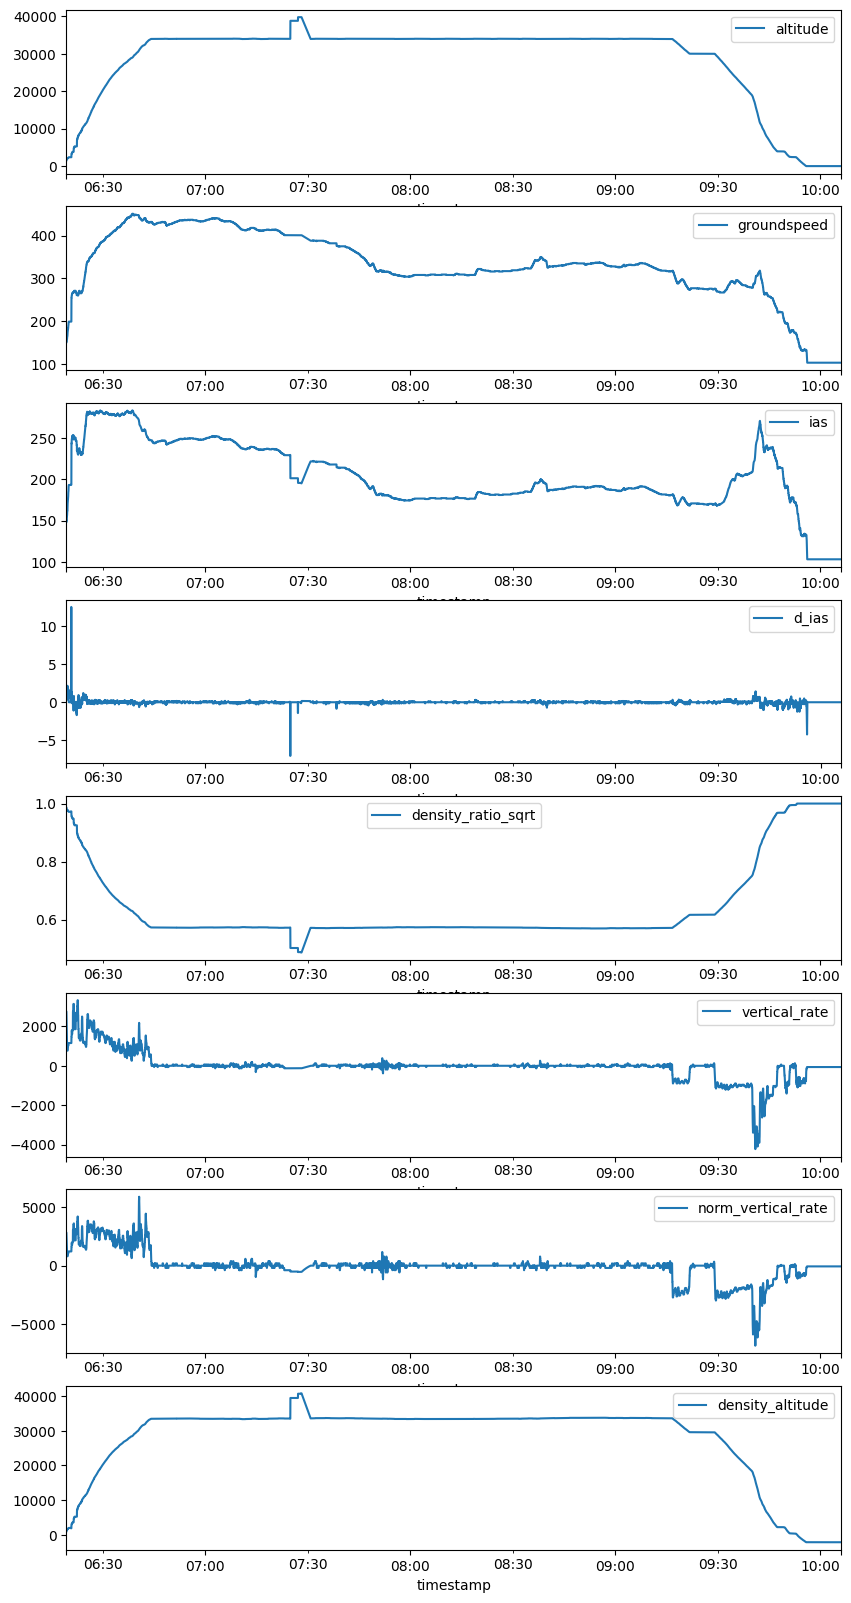

In [7]:
density_ratio_sqrt = np.array([1, 0.985, 0.971, 0.956, 0.942, 0.928, 0.914, 0.900, 0.886, 0.873, 0.859, 0.793, 0.730, 0.670, 0.612, 0.556, 0.496, 0.440, 0.390])
altitude_ft = np.array([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000])

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, 1, figsize=(10, 20))
flight = t[11]

flight.data['temperature'] = flight.data['temperature'].bfill()
flight.data['temperature_celsius'] = flight.data['temperature'] - 273.15
flight.data['standard_temp_at_alt'] = 15 - (2 * (flight.data['altitude'] / 1000))
flight.data['density_altitude'] = flight.data['altitude'] + 120 * (flight.data['temperature_celsius'] - flight.data['standard_temp_at_alt'])

flight.plot_time(ax=ax1, y="altitude")
flight.plot_time(ax=ax2, y="groundspeed")

flight.data['density_ratio_sqrt'] = np.interp(flight.data.density_altitude, altitude_ft, density_ratio_sqrt)
flight.data['ias'] = flight.data.groundspeed * flight.data.density_ratio_sqrt
flight.data['d_ias'] = (flight.data['ias'].shift(-2) - flight.data['ias'].shift(2)) / (flight.data['timestamp'].shift(-2) - flight.data['timestamp'].shift(2)).dt.total_seconds()
flight.data["norm_vertical_rate"] = ((1 / flight.data.density_ratio_sqrt) ** 2) * (flight.data.vertical_rate)

flight.plot_time(ax=ax3, y="ias")

flight.plot_time(ax=ax4, y="d_ias")
flight.plot_time(ax=ax5, y="density_ratio_sqrt")
flight.plot_time(ax=ax6, y="vertical_rate")
flight.plot_time(ax=ax7, y="norm_vertical_rate")
flight.plot_time(ax=ax8, y="density_altitude")
plt.show()

data_back = flight.data.copy(deep=True)

We are only interested in the part where aircraft reaches the cruising atitude

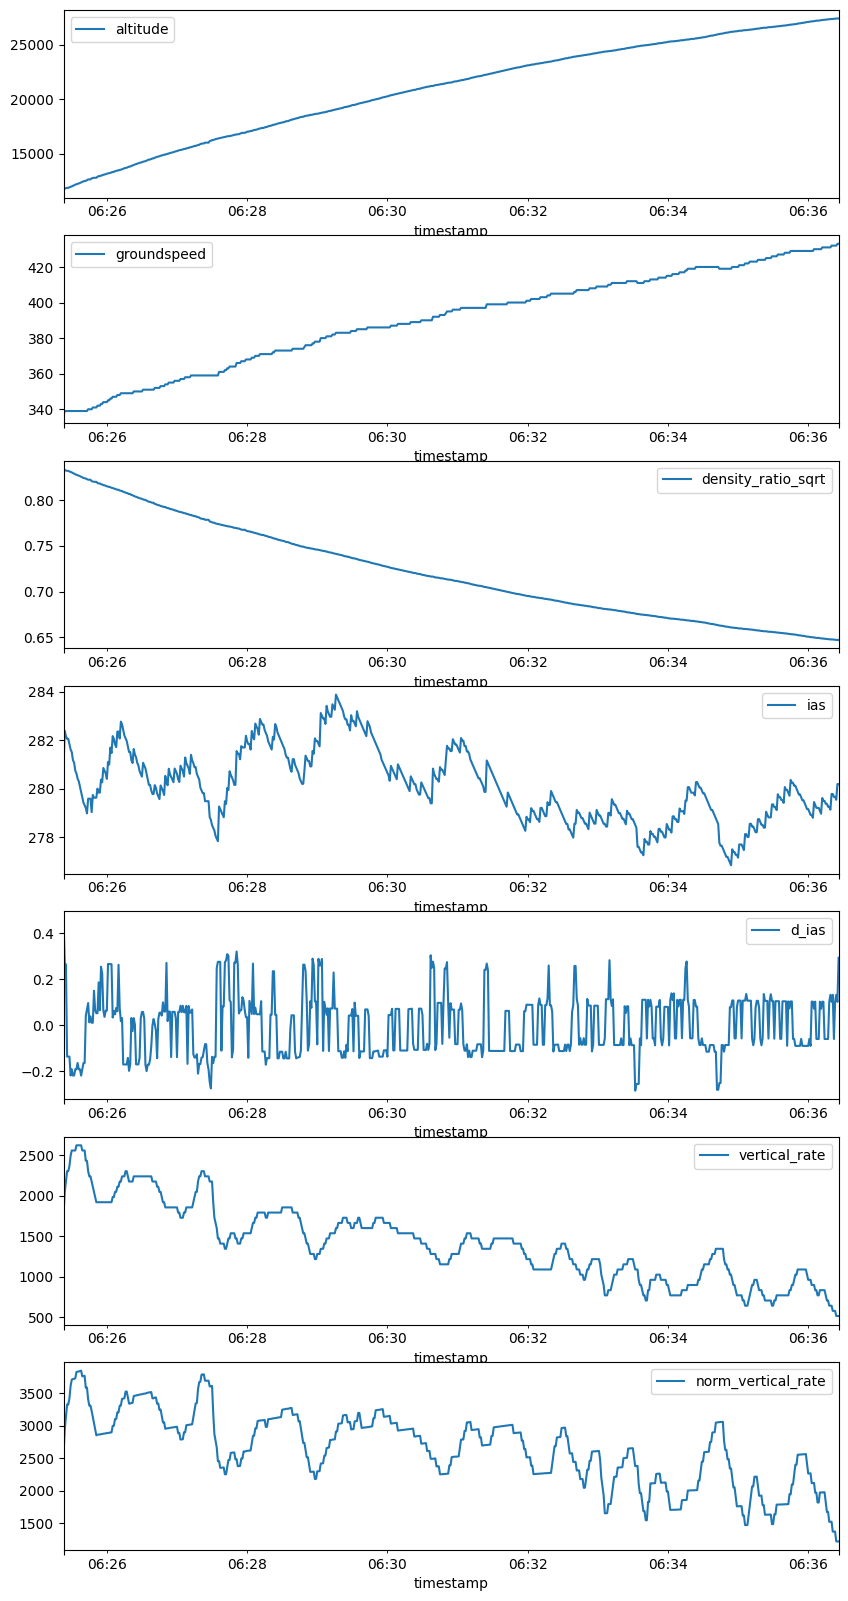

In [8]:
flight.data = data_back
flight.data["condition"] = (flight.data.vertical_rate > 500) & (flight.data.ias > 250) & (flight.data.d_ias < 0.5)
flight.data['group'] = (flight.data['condition'] != flight.data['condition'].shift()).cumsum()
filtered_df = (
    flight.data[flight.data['condition']]  # Keep only rows where condition is True
    .groupby('group')  # Group by consecutive blocks
    .filter(lambda x: (x['timestamp'].max() - x['timestamp'].min()).total_seconds() >= 5 * 60)  # Duration check
)
filtered_df = filtered_df.drop(columns=['condition', 'group'])
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize=(10, 20))
flight.data = filtered_df
flight.plot_time(ax=ax1, y="altitude")
flight.plot_time(ax=ax2, y="groundspeed")
flight.plot_time(ax=ax3, y="density_ratio_sqrt")
flight.plot_time(ax=ax4, y="ias")
flight.plot_time(ax=ax5, y="d_ias")
flight.plot_time(ax=ax6, y="vertical_rate")
flight.plot_time(ax=ax7, y="norm_vertical_rate")
plt.show()